# <a id='toc1_'></a>[3) Cars4You ML Project Price Prediction](#toc0_)

---
**Group 2:**

- Luis Mendes 20221949
- Margarida Ourives 20221809
- Simon Sazonov 20221689 
- Veronica Mendes 20221945

**Group Member Contribution:**
- Luis Mendes:
- Margarida Ourives:
- Simon Sazonov:
- Veronica Mendes:
---


**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc2_)
- [Data Integration](#toc3_)    
- [Modeling](#toc4_)    
  - [Motivations](#toc4_1_)    
  - [Benchmarking](#toc4_2_)    
  - [KNN](#toc4_3_)    
  - [Random Forest](#toc4_4_)    
  - [Neural Networks (NN)](#toc4_5_)    
  - [Analysis Final Model](#toc4_6_)    
    - [Final Model](#toc4_6_1_)    
- [Deployment (Prediction)](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Grid Search
from sklearn.model_selection import ParameterGrid
# Progress
from tqdm import tqdm
# Spliting
from sklearn.model_selection import KFold, StratifiedKFold
# Preprocessing
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Imputation
from sklearn.impute import KNNImputer
# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error
# CV Score and Graphing
from utils import avg_scores, predict_test_set_brand

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_context("notebook")
sns.set_style("ticks")

# <a id='toc3_'></a>[Data Integration](#toc0_)

We will need to use our preprocessed data that is not yet being scaled, encoded, nor imputed, because we will need to perform those steps for each brand of car separately.

In [2]:
# Load the dataset NOT encoded/scaled/imputed
X_M, y_M = pd.read_pickle('../project_data/X_Ylog_ModelOptimization.pkl')

In [8]:
X_M.head()

,Brand,transmission,mileage,mpg,engineSize,Years_old
carID,,,,,,
69512,vw,semi-auto,28421.0,11.417268,2.0,5
53000,toyota,manual,4589.0,47.900000,1.5,2
6366,audi,semi-auto,3624.0,40.900000,1.5,2
29021,ford,manual,9102.0,65.700000,1.0,3
10062,bmw,manual,1000.0,42.800000,1.5,2


# <a id='toc4_'></a>[Modeling](#toc0_)

## <a id='toc4_1_'></a>[Motivations](#toc0_)

We opted to try and implement one model per brand because in the Exploratory Data Analysis (EDA) we saw that we had different numbers of cars per brand, and the prices also varied significantly by brand. So, we believe that a splitting approach to predict the price, depending on the brand, could improve the prediction.

Now, we are going to review what we saw in the EDA, showing the distribution of cars per brand and the price distribution per brand.

Sample count per brand:


,Brand,Samples
0,ford,15673
1,mercedes,11382
2,vw,10121
3,opel,9134
4,bmw,7214
5,audi,7147
6,toyota,4519
7,skoda,4194
8,hyundai,3261


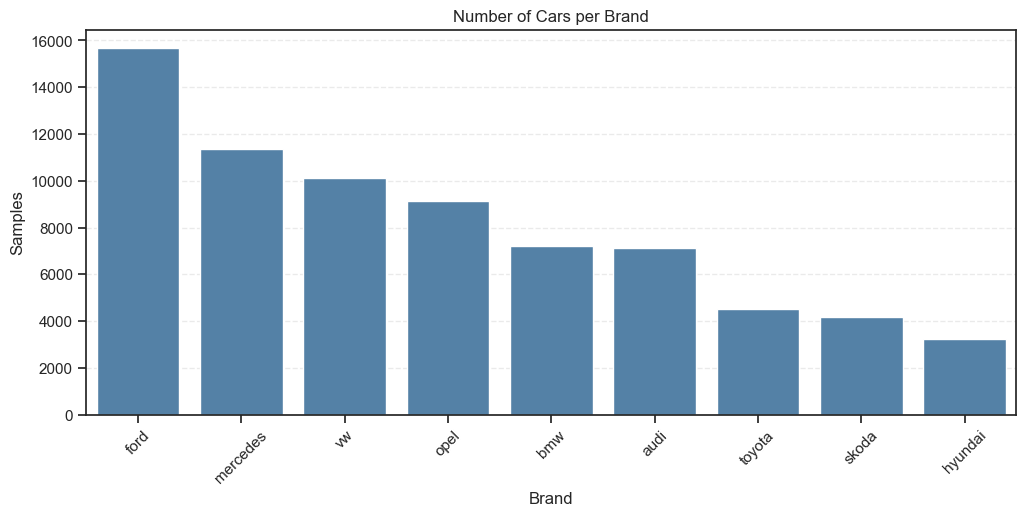

In [ ]:
brand_sizes_df = X_M['Brand'].value_counts().reset_index()
brand_sizes_df.columns = ['Brand', 'Samples']

print("Sample count per brand:")
display(brand_sizes_df)

# Bar plot
plt.figure(figsize=(12,5))
sns.barplot(data=brand_sizes_df, x='Brand', y='Samples', color='steelblue')
plt.title("Number of Cars per Brand")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


As we see, we have different numbers of observations per brand.

Now let's analyze the price distribution per brand.

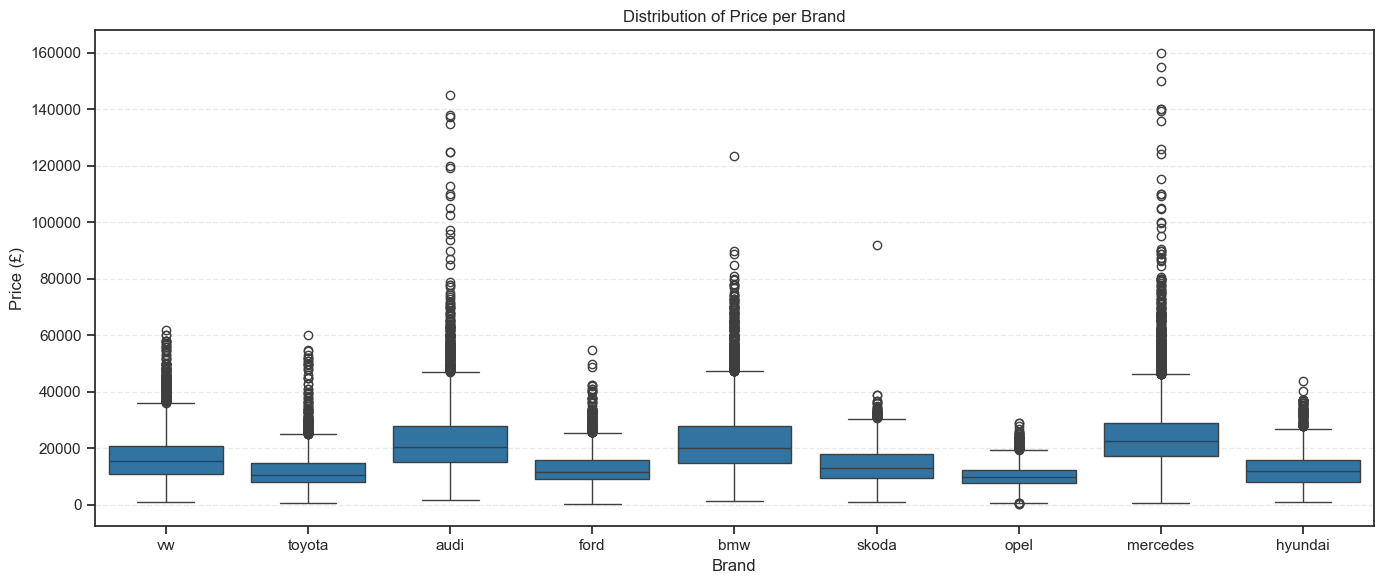

In [12]:
plt.figure(figsize=(14,6))
# Build DataFrame from brand y_train Series (Series -> DataFrame with column 'price')

df_prices = X_M[['Brand']].copy()
df_prices['price'] = np.exp(y_M)  # Reverse log-transform to get actual prices

sns.boxplot(data=df_prices, x='Brand', y='price')
plt.title("Distribution of Price per Brand")
plt.ylabel('Price (£)')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

So, we confirm that the prices depend a lot on the brands, meaning that the price distribution changes depending on the brand. For that reason, we will try to find a good model for each brand and then use it to try to have better predictions.

To do so, we will use Cross-Validation (CV) to evaluate the models (since in this case we have a small number of samples, so we will opt for a more robust method to search and evaluate the models), starting with an evaluation on a Linear Regression (that will be the benchmark for each brand), and then continuing with KNN, Random Forest (RF), and Neural Networks (NN). We won't use Decision Trees (DT) nor AdaBoost since they performed very similarly or worse than the RF in the general model.

To find the parameters, we will test something that is inside the bounds of the ones used on the 'all brands' approach, since that range already considered all the brands and should be more than enough to find something meaningful here. And to compare performance we will opt for the same conditions as on the 'all brands' models; we will look for a good (small) validation MAE, with overfitting less than £200, and preferably a simpler model.

Note: On each fold and specifically for each brand, we will need to resolve the missing values, encode, and scale the variables, and then see the performance of the model for each brand.

## <a id='toc4_2_'></a>[Benchmarking](#toc0_)

We will start seeing the results of the models for each brand using Linear Regression (LR), which will serve as the benchmark.

We will define some dictionaries to save the scores, the unique brands that are on our dataset and we will define the Cross-Validation (CV) method.

In [3]:
brands_LR_train_cv = {}
brands_LR_val_cv = {}

method_CV = KFold(n_splits= 6, random_state = 22, shuffle= True)

brands = list(X_M['Brand'].unique())
brands

['vw', 'toyota', 'audi', 'ford', 'bmw', 'skoda', 'opel', 'mercedes', 'hyundai']

In [ ]:
for brand in brands:

    mask = X_M['Brand'] == brand

    X_brand = X_M.loc[mask].copy()
    y_brand = y_M.loc[mask].copy()

    X_brand.drop(columns=['Brand'], inplace=True)

    avg_scores(
        X = X_brand,
        y = y_brand,
        CV = method_CV,
        imputer = KNNImputer(n_neighbors=10, weights='uniform'),
        scalar = RobustScaler(),
        model = LinearRegression(),
        score_train_dic = brands_LR_train_cv,
        score_val_dic = brands_LR_val_cv,
        dic_key = brand,
        log_transform = True
    )

6it [00:02,  2.79it/s]
6it [00:02,  2.50it/s]
6it [00:33,  5.62s/it]
6it [00:00,  7.49it/s]
6it [00:17,  2.87s/it]
6it [00:03,  1.87it/s]
6it [00:00,  6.18it/s]
6it [00:01,  5.44it/s]
6it [00:03,  1.67it/s]


And we will save those results into a DataFrame, where we will store the best results per each type of model for each car brand. To compare at the end after testing the other models.

In [95]:
# Create DataFrame from CV dictionaries
rows = []
for brand in brands_LR_train_cv.keys():
    train_mae = brands_LR_train_cv[brand]
    val_mae = brands_LR_val_cv[brand]
    rows.append({
        "brand": brand,
        "model": 'LR',
        "train_mae": train_mae[0],
        "val_mae": val_mae[0],
        "overfitting": val_mae[0] - train_mae[0],
        "std_train_mae": train_mae[1],
        "std_val_mae": val_mae[1]
    })

df_CV_brands = pd.DataFrame(rows)

df_CV_brands

,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
0,audi,LR,2972.82,2975.45,2.63,10.04,52.96
1,bmw,LR,3750.87,3755.33,4.46,40.97,206.95
2,ford,LR,1690.82,1692.00,1.18,5.40,31.57
3,hyundai,LR,2049.72,2054.01,4.29,12.48,51.90
4,mercedes,LR,3449.36,3452.06,2.70,11.91,66.79
5,opel,LR,1573.57,1575.20,1.63,6.01,31.12
6,skoda,LR,2068.61,2074.42,5.81,16.36,64.12
7,toyota,LR,1757.62,1759.43,1.81,17.74,74.75
8,vw,LR,2466.68,2469.27,2.59,15.11,66.08


## <a id='toc4_3_'></a>[KNN](#toc0_)

We will start by testing how a KNN Regressor performs for each brand. The hyperparameters that we are going to test are the same as the 'all brands': uniform weights with number of neighbors (k) between 7 and 100. We will save the results for each model and brand after applying Cross-Validation (CV) to later compare performance and choose the best hyperparameters.

In [39]:
# Define the parameters to test
param_grid = {'n_neighbors': list(range(7, 101))}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
brand_train_knn = {}
brand_val_knn = {}

In [ ]:
# For each paramater 
for params in tqdm(grid):
   
   # for each brand (dicts and name of brands)
   for brand in brands:

      mask = X_M['Brand'] == brand

      X_brand = X_M.loc[mask].copy()
      y_brand = y_M.loc[mask].copy()

      X_brand.drop(columns=['Brand'], inplace=True)
      
      # CV MAE
      avg_scores(
         X = X_brand,
         y = y_brand,
         CV = method_CV,
         imputer = KNNImputer(n_neighbors=10, weights='uniform'),
         scalar = RobustScaler(),
         model = KNeighborsRegressor(n_neighbors=params['n_neighbors'], weights='uniform', n_jobs=-1),
         score_train_dic = brand_train_knn,
         score_val_dic = brand_val_knn,
         dic_key = (brand, str(params['n_neighbors'])),
         log_transform = True
      )

6it [00:03,  1.95it/s][00:00<?, ?it/s]
6it [00:02,  2.20it/s]
6it [00:33,  5.66s/it]
6it [00:01,  4.91it/s]
6it [00:16,  2.80s/it]
6it [00:03,  1.62it/s]
6it [00:01,  4.10it/s]
6it [00:01,  3.43it/s]
6it [00:04,  1.47it/s]
6it [00:03,  1.75it/s][01:09<1:47:00, 69.04s/it]
6it [00:02,  2.03it/s]
6it [00:30,  5.09s/it]
6it [00:01,  4.48it/s]
6it [00:17,  2.91s/it]
6it [00:03,  1.63it/s]
6it [00:01,  3.93it/s]
6it [00:01,  3.30it/s]
6it [00:04,  1.29it/s]
6it [00:02,  2.01it/s][02:16<1:44:38, 68.25s/it]
6it [00:02,  2.01it/s]
6it [00:30,  5.06s/it]
6it [00:01,  4.81it/s]
6it [00:16,  2.69s/it]
6it [00:03,  1.60it/s]
6it [00:01,  4.27it/s]
6it [00:01,  3.46it/s]
6it [00:04,  1.46it/s]
6it [00:03,  1.98it/s][03:21<1:41:14, 66.75s/it]
6it [00:02,  2.10it/s]
6it [00:30,  5.04s/it]
6it [00:01,  5.10it/s]
6it [00:16,  2.71s/it]
6it [00:03,  1.53it/s]
6it [00:01,  3.54it/s]
6it [00:02,  2.97it/s]
6it [00:04,  1.25it/s]
6it [00:02,  2.04it/s][04:28<1:39:51, 66.57s/it]
6it [00:03,  1.89it/s]
6it [0

Now let's analyze the results, looking at the overfitting, training MAE, and validation MAE, depending on the brand.

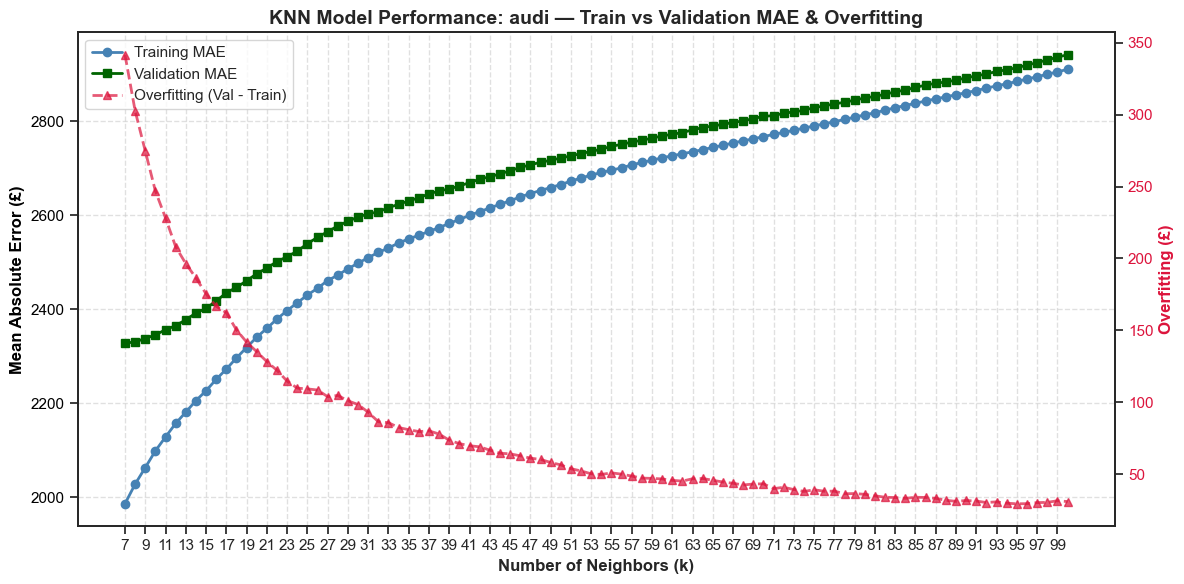

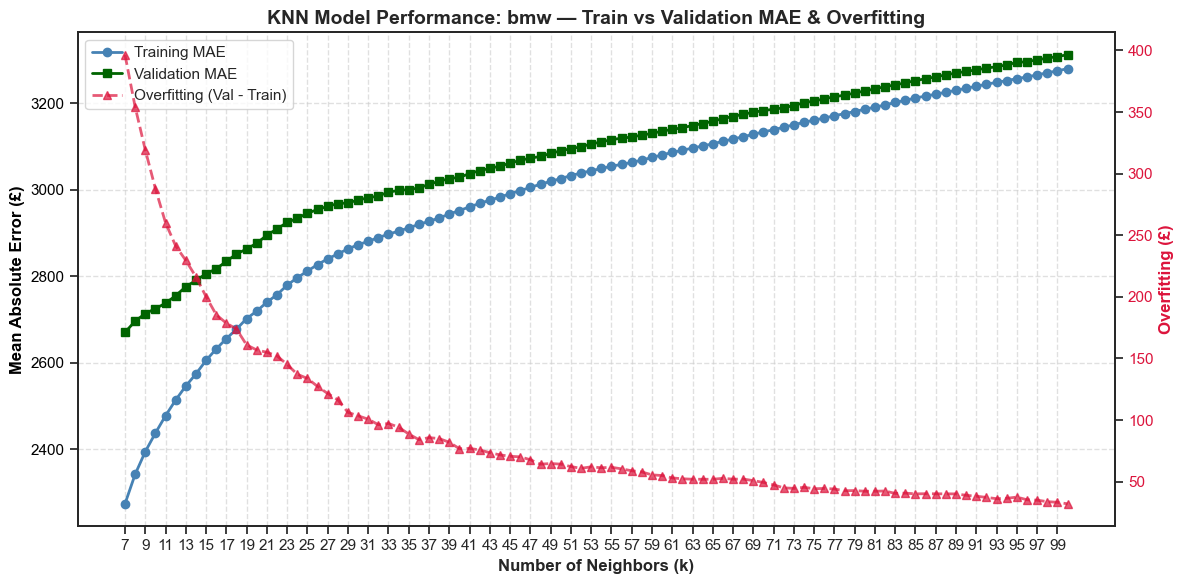

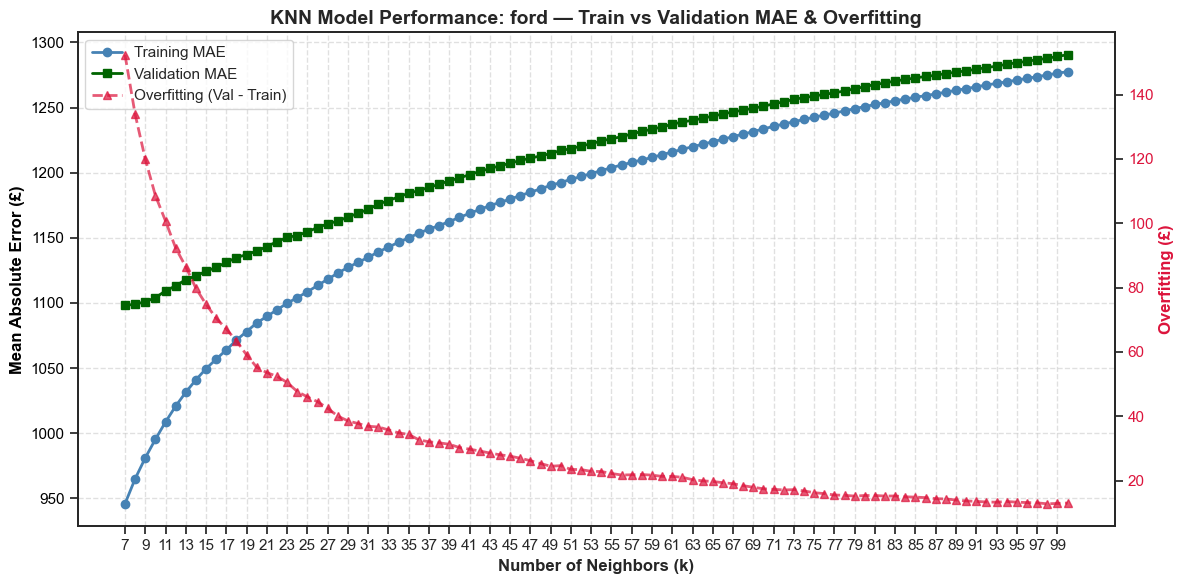

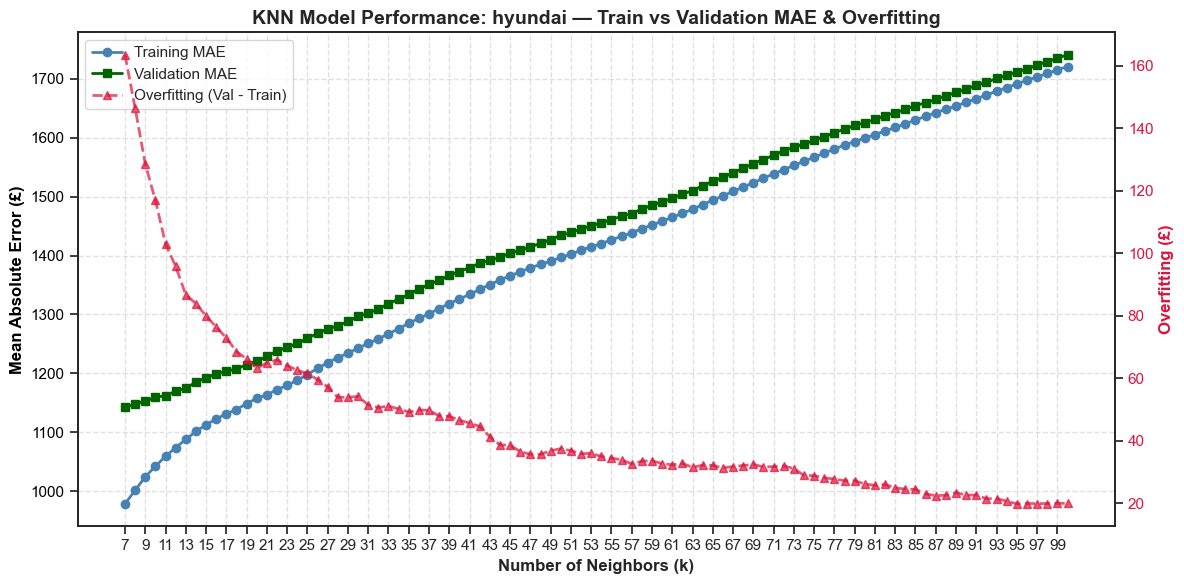

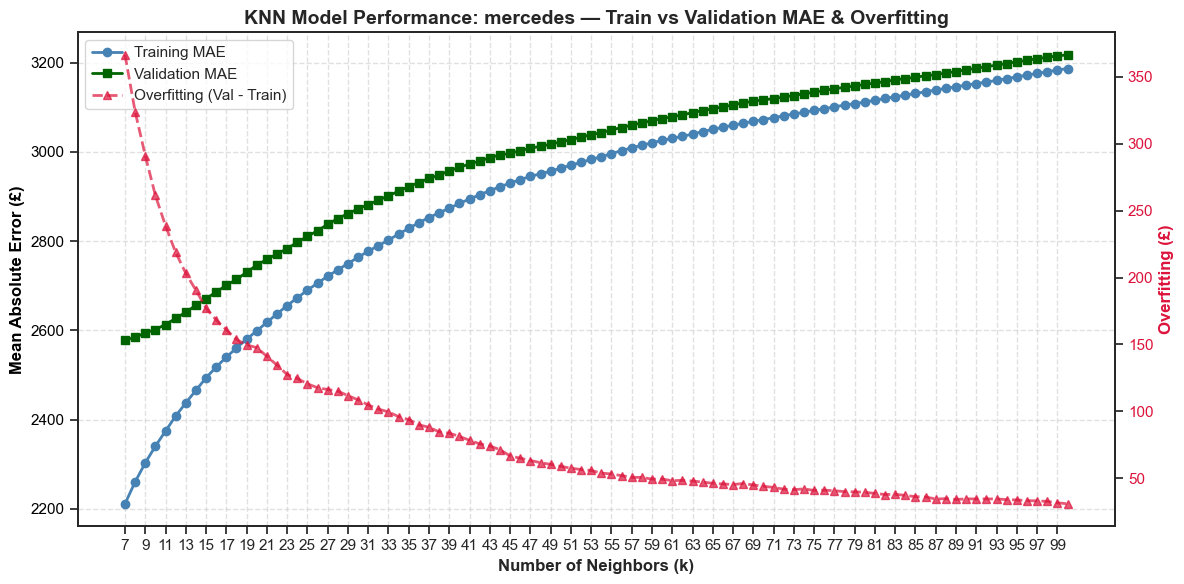

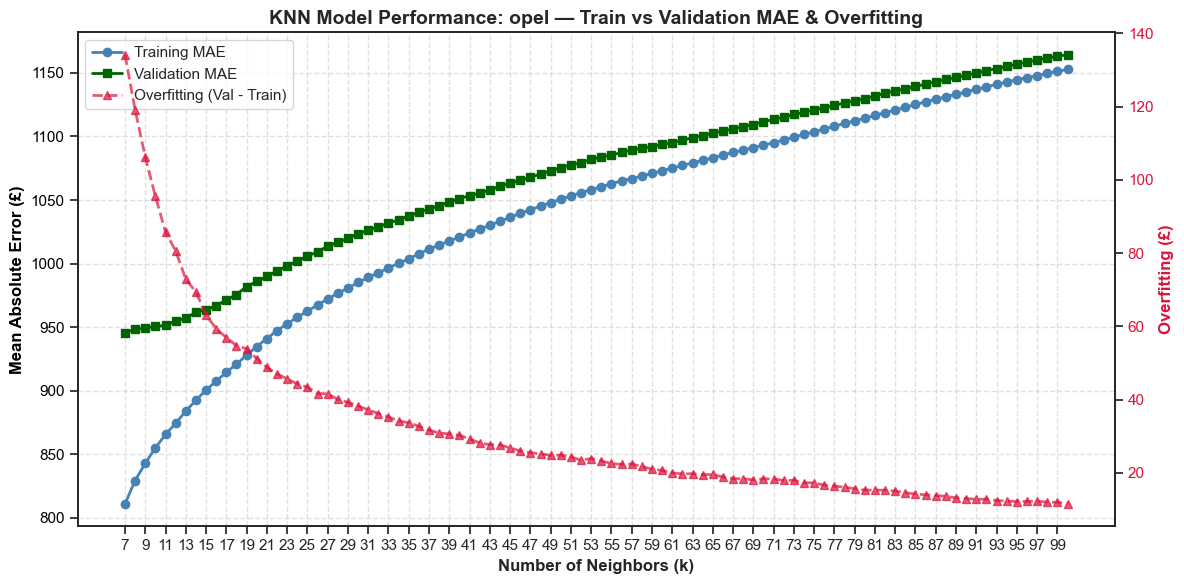

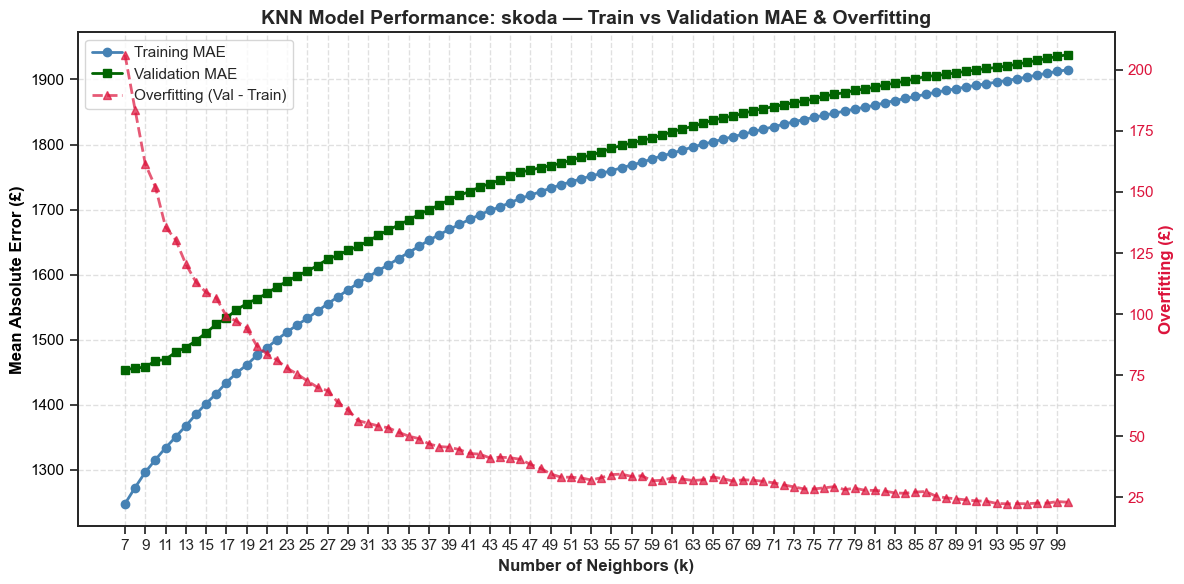

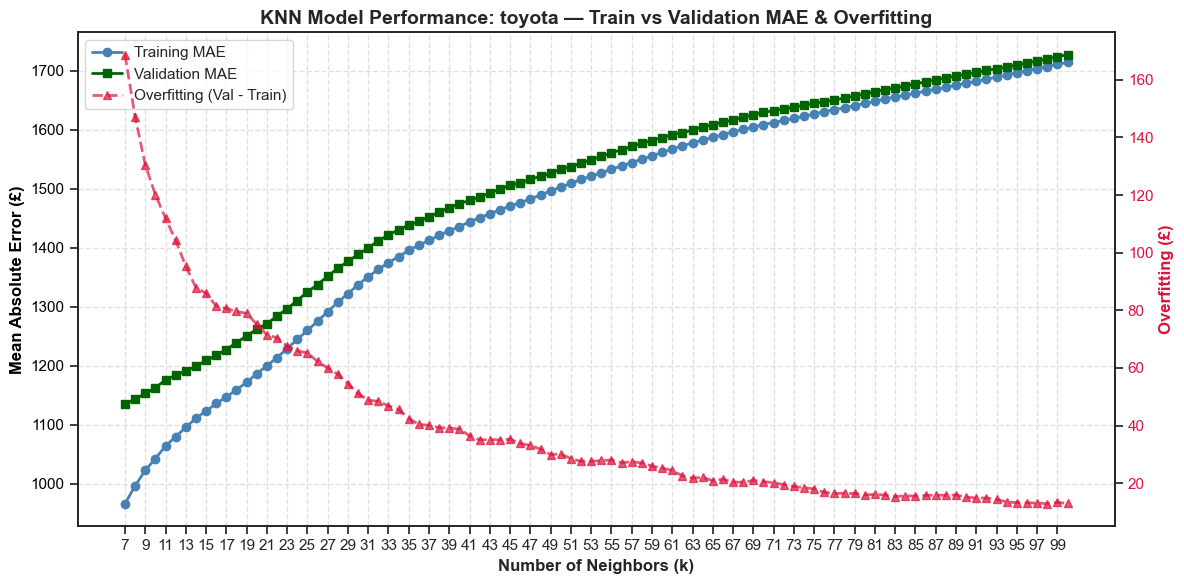

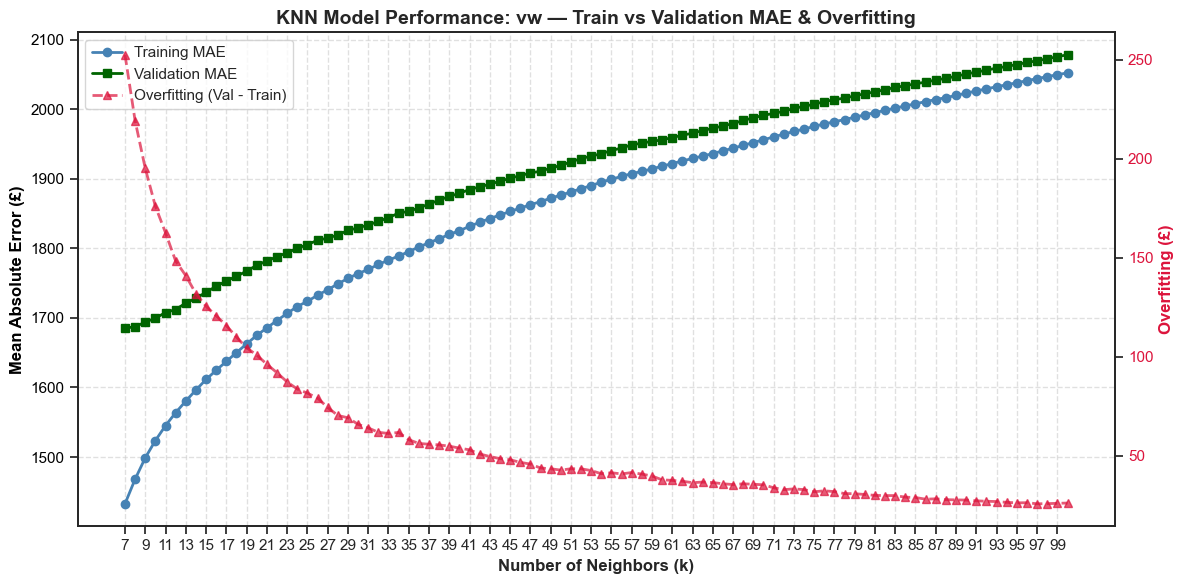

In [46]:
# For loop to display KNN performance graph for each brand
for brand in brands:

    # Extract keys and values from dictionaries for this brand
    neighbors = sorted([int(key[1]) for key in brand_train_knn.keys() if key[0] == brand])
        
    train_mae = [brand_train_knn[(brand, str(n))][0] for n in neighbors]
    val_mae = [brand_val_knn[(brand, str(n))][0] for n in neighbors]
    
    # Calculate overfitting (difference between validation and training MAE)
    overfitting = np.subtract(val_mae, train_mae)
    
    # Create figure with primary and secondary y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot train and validation MAE on primary y-axis
    ax1.plot(neighbors, train_mae, marker='o', linewidth=2, label='Training MAE', color='steelblue')
    ax1.plot(neighbors, val_mae, marker='s', linewidth=2, label='Validation MAE', color='darkgreen')
    ax1.set_xlabel('Number of Neighbors (k)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Mean Absolute Error (£)', fontsize=12, fontweight='bold', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Create secondary y-axis for overfitting
    ax2 = ax1.twinx()
    ax2.plot(neighbors, overfitting, marker='^', linewidth=2, label='Overfitting (Val - Train)', 
             color='crimson', linestyle='--', alpha=0.7)
    ax2.set_ylabel('Overfitting (£)', fontsize=12, fontweight='bold', color='crimson')
    ax2.tick_params(axis='y', labelcolor='crimson')
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=11, loc='best')
    
    plt.title(f'KNN Model Performance: {brand} — Train vs Validation MAE & Overfitting', 
              fontsize=14, fontweight='bold')
    plt.xticks(range(7, 101,2))
    fig.tight_layout()
    plt.show()

Concluding and explaining the reasoning for each choice of hyperparameters for the brand:
+ **Audi**: We chose k=23 because it is the first model where the overfitting decreased substantially and stabilized (after this point, the overfitting did not improve much or was maintained). This represents the best balance between validation MAE and overffiting.
+ **BMW**: We chose k=40 for the same reason (overfitting stabilization).
+ **Ford**: We chose k=29 for the same reason (overfitting stabilization).
+ **Hyundai**: We chose k=20 because it had a good validation MAE score, and the subsequent models started to overfit more.
+ **Mercedes**: We chose k=25 when the improvement in overfitting stopped; the overfitting was not too large, and the validation MAE was good (the next reduction in overfitting evolution had a very bad MAE for the validation.).
+ **Opel**: We chose k=18 because it had very low overfitting and a good validation MAE. Choosing a model with less overfitting later did not compensate for the worsening validation MAE score.
+ **Skoda**: We chose k=30 for the same reason (low overfitting and good validation MAE trade-off).
+ **Toyota**: We chose k=16 because it had very low overfitting and a good validation MAE. Choosing a model with less overfitting later did not compensate for the worsening validation MAE score.
+ **VW**: We chose k=35 for the same reason (low overfitting and good validation MAE trade-off).

And now we will save the results of the best models per each brand into the dataframe that will have all of our best models by brand.

In [96]:
# Add the new row to df_CV_brands
best_kkn_brand = [('audi', 23),
                    ('bmw', 40),
                    ('ford', 29),
                    ('hyundai', 20),
                    ('mercedes', 25),
                    ('opel', 18),
                    ('skoda', 30),
                    ('toyota', 16),
                    ('vw', 35)]

for brand, k in best_kkn_brand:
    train_mae = brand_train_knn[(brand, str(k) )]
    val_mae = brand_val_knn[(brand, str(k))]

    new_row = pd.DataFrame([{
        "brand" : brand,
        "model": 'KNN',
        "train_mae": train_mae[0],
        "val_mae": val_mae[0],
        "overfitting": val_mae[0] - train_mae[0],
        "std_train_mae": train_mae[1],
        "std_val_mae": val_mae[1]
    }])

    df_CV_brands = pd.concat([df_CV_brands, new_row], ignore_index=True)

df_CV_brands

,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
0,audi,LR,2972.82,2975.45,2.63,10.04,52.96
1,bmw,LR,3750.87,3755.33,4.46,40.97,206.95
2,ford,LR,1690.82,1692.00,1.18,5.40,31.57
3,hyundai,LR,2049.72,2054.01,4.29,12.48,51.90
4,mercedes,LR,3449.36,3452.06,2.70,11.91,66.79
5,opel,LR,1573.57,1575.20,1.63,6.01,31.12
6,skoda,LR,2068.61,2074.42,5.81,16.36,64.12
7,toyota,LR,1757.62,1759.43,1.81,17.74,74.75
8,vw,LR,2466.68,2469.27,2.59,15.11,66.08
9,audi,KNN,2396.97,2511.60,114.63,15.17,47.82


## <a id='toc4_4_'></a>[Random Forest](#toc0_)

We will continue by testing how a Random Forest and Bagging of Decision Trees (when the max features are 6, that represents all features) performs for each brand. The hyperparameters that we are going to test are similar as the 'all brands' model, we reduce some of them because it leads to same results and this models should be more simpler, since there are per model less observations. The are the followings: n_estimators = [25, 50, 100], max_samples = [0.33, 0.66, 1.0], max_depth = [4, 14, None], min_samples_split = [2, 50, 100], max_features = [3, 6]. The criterion will be the absolute error and we will bootstrap the samples.

We will save the results for each model and brand after applying Cross-Validation (CV) to later compare performance and choose the best hyperparameters.

In [81]:
# Define the parameters to test
param_grid = {
    "n_estimators": [25, 50, 100],
    "max_samples" : [0.33, 0.66, 1.0],        
    "max_depth": [4, 14, None],          
    "min_samples_split": [2, 50, 100],    
    "max_features": [3, 6]
}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
brand_train_RF = {}
brand_val_RF = {}

In [82]:
# For each paramater 
for params in tqdm(grid):
   
   # for each brand (dicts and name of brands)
   for brand in brands:

      mask = X_M['Brand'] == brand

      X_brand = X_M.loc[mask].copy()
      y_brand = y_M.loc[mask].copy()

      X_brand.drop(columns=['Brand'], inplace=True)
      
      # CV MAE
      avg_scores(
         X = X_brand,
         y = y_brand,
         CV = method_CV,
         imputer = KNNImputer(n_neighbors=10, weights='uniform'),
         scalar = RobustScaler(),
         model = RandomForestRegressor(random_state=22,
                                n_estimators = params['n_estimators'],
                                max_depth= params['max_depth'],
                                min_samples_split= params['min_samples_split'],
                                max_features= params['max_features'],
                                max_samples= params['max_samples'],
                                bootstrap=True,
                                criterion='absolute_error',
                                n_jobs=-1),
         score_train_dic = brand_train_RF,
         score_val_dic = brand_val_RF,
         dic_key = (brand, params['n_estimators'], params['max_depth'], params['min_samples_split'], params['max_features'], params['max_samples']),
         log_transform = True
      )

6it [00:04,  1.40it/s] [00:00<?, ?it/s]
6it [00:04,  1.29it/s]
6it [00:40,  6.82s/it]
6it [00:01,  3.16it/s]
6it [00:21,  3.63s/it]
6it [00:06,  1.06s/it]
6it [00:02,  2.53it/s]
6it [00:02,  2.58it/s]
6it [00:07,  1.25s/it]
6it [00:06,  1.06s/it] [01:32<4:07:37, 92.28s/it]
6it [00:06,  1.07s/it]
6it [00:45,  7.63s/it]
6it [00:02,  2.14it/s]
6it [00:28,  4.70s/it]
6it [00:10,  1.75s/it]
6it [00:03,  1.59it/s]
6it [00:03,  1.65it/s]
6it [00:11,  1.91s/it]
6it [00:12,  2.00s/it] [03:31<4:48:23, 108.15s/it]
6it [00:12,  2.03s/it]
6it [01:09, 11.55s/it]
6it [00:04,  1.27it/s]
6it [00:41,  6.93s/it]
6it [00:16,  2.83s/it]
6it [00:05,  1.15it/s]
6it [00:05,  1.02it/s]
6it [00:18,  3.11s/it]
6it [00:04,  1.40it/s] [06:38<6:21:43, 144.05s/it]
6it [00:04,  1.27it/s]
6it [00:38,  6.34s/it]
6it [00:02,  2.74it/s]
6it [00:22,  3.75s/it]
6it [00:07,  1.22s/it]
6it [00:03,  1.89it/s]
6it [00:02,  2.32it/s]
6it [00:08,  1.37s/it]
6it [00:07,  1.21s/it] [08:11<5:26:28, 123.98s/it]
6it [00:07,  1.22s/it

In [ ]:
# Create DataFrame from RF dictionaries
rows = []
for brand, n_estimators, max_depth, min_samples_split, max_features, max_samples in brand_train_RF.keys():
    train_mae = brand_train_RF[(brand, n_estimators, max_depth, min_samples_split, max_features, max_samples)]
    val_mae = brand_val_RF[(brand, n_estimators, max_depth, min_samples_split, max_features, max_samples)]
    rows.append({
        "brand" : brand,
        "n_estimators" : n_estimators,
        "max_depth" : max_depth,
        "min_samples_split" : min_samples_split,
        "max_features" : max_features,
        "max_samples" : max_samples, 
        "train_mae": train_mae[0],
        "val_mae": val_mae[0],
        "overfitting": val_mae[0] - train_mae[0],
        "std_train_mae": train_mae[1],
        "std_val_mae": val_mae[1]
    })

df_RF_models = pd.DataFrame(rows)

And now we will analyze only the top 15 models that had an overfitting less than £200 and had the best validation MAE (we will analyze using the scores and not visualizations, because there are many combinations and many brands).

In [93]:
for brand in brands:
    filtered_df = df_RF_models[(df_RF_models['brand'] == brand) & (df_RF_models['overfitting'] < 200)].sort_values('val_mae', ascending=True)
    display(filtered_df.head(15))

,brand,n_estimators,max_depth,min_samples_split,max_features,max_samples,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
1332,audi,50,NaN,50,6,0.66,2148.77,2346.14,197.37,13.32,37.72
846,audi,50,14.0,50,6,0.66,2149.84,2346.29,196.45,13.52,36.96
1341,audi,100,NaN,50,6,0.66,2150.54,2347.30,196.76,14.76,37.48
855,audi,100,14.0,50,6,0.66,2152.09,2347.95,195.86,14.74,36.65
837,audi,25,14.0,50,6,0.66,2156.34,2355.55,199.21,17.23,34.35
1098,audi,100,NaN,50,3,0.66,2190.03,2358.71,168.68,10.41,32.77
612,audi,100,14.0,50,3,0.66,2192.11,2361.39,169.28,11.70,28.30
1089,audi,50,NaN,50,3,0.66,2207.75,2373.84,166.09,9.26,38.44
603,audi,50,14.0,50,3,0.66,2209.45,2374.07,164.62,15.02,38.58
594,audi,25,14.0,50,3,0.66,2221.38,2383.79,162.41,8.25,42.68


,brand,n_estimators,max_depth,min_samples_split,max_features,max_samples,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
838,bmw,25,14.0,50,6,0.66,2451.85,2649.68,197.83,34.67,174.03
1099,bmw,100,NaN,50,3,0.66,2520.65,2710.26,189.61,27.86,185.11
613,bmw,100,14.0,50,3,0.66,2532.70,2712.28,179.58,28.14,184.90
1090,bmw,50,NaN,50,3,0.66,2527.32,2720.44,193.12,31.04,179.28
604,bmw,50,14.0,50,3,0.66,2540.27,2722.64,182.37,30.27,181.69
1081,bmw,25,NaN,50,3,0.66,2534.53,2731.80,197.27,29.56,188.13
595,bmw,25,14.0,50,3,0.66,2549.03,2733.97,184.94,30.96,189.16
1261,bmw,100,NaN,50,6,0.33,2670.61,2796.60,125.99,38.18,188.15
775,bmw,100,14.0,50,6,0.33,2672.83,2797.93,125.10,38.39,187.67
1252,bmw,50,NaN,50,6,0.33,2679.52,2801.81,122.29,37.79,194.35


,brand,n_estimators,max_depth,min_samples_split,max_features,max_samples,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
506,ford,100,14.0,2,3,0.33,844.88,1026.00,181.12,3.08,19.88
749,ford,100,14.0,2,6,0.33,832.70,1026.76,194.06,3.17,18.34
497,ford,50,14.0,2,3,0.33,849.76,1028.77,179.01,2.52,22.21
740,ford,50,14.0,2,6,0.33,837.37,1029.79,192.42,4.47,17.40
488,ford,25,14.0,2,3,0.33,856.15,1037.93,181.78,4.99,23.85
731,ford,25,14.0,2,6,0.33,844.39,1037.98,193.59,4.78,18.72
1424,ford,100,NaN,50,6,1.00,946.57,1067.89,121.32,3.03,24.69
1415,ford,50,NaN,50,6,1.00,947.95,1069.06,121.11,3.23,24.34
1172,ford,50,NaN,50,3,1.00,967.48,1069.10,101.62,4.08,20.37
938,ford,100,14.0,50,6,1.00,955.39,1069.56,114.17,3.50,24.57


,brand,n_estimators,max_depth,min_samples_split,max_features,max_samples,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
696,hyundai,100,14.0,50,3,1.00,1094.61,1197.13,102.52,13.23,61.24
1182,hyundai,100,NaN,50,3,1.00,1094.73,1197.70,102.97,13.44,60.49
687,hyundai,50,14.0,50,3,1.00,1103.26,1212.02,108.76,14.99,60.39
1173,hyundai,50,NaN,50,3,1.00,1103.43,1212.69,109.26,14.71,60.30
678,hyundai,25,14.0,50,3,1.00,1110.77,1223.14,112.37,12.25,71.04
1164,hyundai,25,NaN,50,3,1.00,1111.30,1225.20,113.90,11.88,70.60
1425,hyundai,100,NaN,50,6,1.00,1109.49,1232.14,122.65,14.85,65.12
939,hyundai,100,14.0,50,6,1.00,1109.64,1232.19,122.55,14.84,65.15
1416,hyundai,50,NaN,50,6,1.00,1110.67,1234.68,124.01,13.60,67.12
930,hyundai,50,14.0,50,6,1.00,1110.80,1234.80,124.00,13.56,67.10


,brand,n_estimators,max_depth,min_samples_split,max_features,max_samples,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
1345,mercedes,100,NaN,50,6,0.66,2287.67,2472.57,184.90,11.31,68.87
859,mercedes,100,14.0,50,6,0.66,2300.73,2476.35,175.62,12.20,68.90
1336,mercedes,50,NaN,50,6,0.66,2288.77,2476.45,187.68,13.70,69.11
850,mercedes,50,14.0,50,6,0.66,2301.89,2480.71,178.82,14.56,69.08
1327,mercedes,25,NaN,50,6,0.66,2299.52,2487.92,188.40,17.43,70.90
841,mercedes,25,14.0,50,6,0.66,2311.19,2491.39,180.20,18.26,71.17
688,mercedes,50,14.0,50,3,1.00,2297.68,2496.94,199.26,14.46,78.50
679,mercedes,25,14.0,50,3,1.00,2310.19,2509.45,199.26,15.66,79.39
1102,mercedes,100,NaN,50,3,0.66,2379.86,2550.65,170.79,15.99,80.25
1093,mercedes,50,NaN,50,3,0.66,2381.31,2554.20,172.89,15.47,78.27


,brand,n_estimators,max_depth,min_samples_split,max_features,max_samples,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
752,opel,100,14.0,2,6,0.33,680.70,858.88,178.18,1.67,10.48
509,opel,100,14.0,2,3,0.33,695.16,862.07,166.91,2.83,12.95
743,opel,50,14.0,2,6,0.33,684.98,863.69,178.71,2.05,11.02
500,opel,50,14.0,2,3,0.33,699.81,865.20,165.39,2.15,13.83
734,opel,25,14.0,2,6,0.33,692.53,870.60,178.07,2.52,10.90
491,opel,25,14.0,2,3,0.33,708.53,873.45,164.92,2.17,12.28
1427,opel,100,NaN,50,6,1.00,809.40,899.48,90.08,2.86,7.69
941,opel,100,14.0,50,6,1.00,812.77,899.60,86.83,2.72,8.04
1418,opel,50,NaN,50,6,1.00,810.55,900.50,89.95,3.43,7.00
932,opel,50,14.0,50,6,1.00,813.95,900.82,86.87,3.16,7.36


,brand,n_estimators,max_depth,min_samples_split,max_features,max_samples,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
1185,skoda,100,NaN,50,3,1.00,1332.70,1462.87,130.17,9.86,59.51
699,skoda,100,14.0,50,3,1.00,1333.17,1463.38,130.21,10.79,57.99
1176,skoda,50,NaN,50,3,1.00,1336.74,1467.63,130.89,11.22,55.50
1167,skoda,25,NaN,50,3,1.00,1343.20,1468.69,125.49,17.96,46.52
690,skoda,50,14.0,50,3,1.00,1338.80,1469.63,130.83,12.26,53.20
924,skoda,25,14.0,50,6,1.00,1334.62,1473.22,138.60,13.74,43.92
1410,skoda,25,NaN,50,6,1.00,1333.71,1473.25,139.54,13.53,44.16
681,skoda,25,14.0,50,3,1.00,1345.24,1473.94,128.70,17.92,48.30
1419,skoda,50,NaN,50,6,1.00,1331.49,1474.99,143.50,16.54,43.46
933,skoda,50,14.0,50,6,1.00,1332.78,1475.16,142.38,16.95,43.72


,brand,n_estimators,max_depth,min_samples_split,max_features,max_samples,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
943,toyota,100,14.0,50,6,1.00,935.87,1062.59,126.72,8.55,54.55
1429,toyota,100,NaN,50,6,1.00,934.90,1062.71,127.81,8.42,54.61
934,toyota,50,14.0,50,6,1.00,937.21,1064.44,127.23,8.90,58.65
1420,toyota,50,NaN,50,6,1.00,936.41,1064.56,128.15,8.71,58.64
1411,toyota,25,NaN,50,6,1.00,941.73,1069.02,127.29,9.07,57.35
925,toyota,25,14.0,50,6,1.00,942.39,1070.02,127.63,9.82,57.42
1186,toyota,100,NaN,50,3,1.00,970.58,1073.14,102.56,7.61,42.56
700,toyota,100,14.0,50,3,1.00,971.85,1073.31,101.46,9.72,42.10
1177,toyota,50,NaN,50,3,1.00,975.39,1081.18,105.79,4.33,46.97
691,toyota,50,14.0,50,3,1.00,977.68,1082.32,104.64,8.67,45.98


,brand,n_estimators,max_depth,min_samples_split,max_features,max_samples,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
1187,vw,100,NaN,50,3,1.00,1454.29,1600.52,146.23,9.21,43.55
701,vw,100,14.0,50,3,1.00,1457.51,1601.15,143.64,7.58,44.26
1178,vw,50,NaN,50,3,1.00,1455.62,1604.50,148.88,10.85,43.60
692,vw,50,14.0,50,3,1.00,1460.29,1606.63,146.34,8.95,46.12
683,vw,25,14.0,50,3,1.00,1466.76,1609.91,143.15,11.56,41.42
1169,vw,25,NaN,50,3,1.00,1460.75,1611.38,150.63,12.51,42.57
1430,vw,100,NaN,50,6,1.00,1448.92,1621.94,173.02,6.92,41.94
944,vw,100,14.0,50,6,1.00,1454.97,1624.25,169.28,7.36,41.20
1421,vw,50,NaN,50,6,1.00,1450.79,1627.16,176.37,7.82,41.24
935,vw,50,14.0,50,6,1.00,1456.64,1628.97,172.33,8.25,40.80


For all brands, the overarching goal was to find the simplest model that achieved a good Validation MAE while maintaining an overfitting gap below £200, and here are the results (there is the brand, n_estimators	max_depth, min_samples_split, max_features, max_samples):
+ **Audi (50, 14.0, 50, 3, 0.66)**, we selected the simpler model that comfortably met the performance criteria while ensuring the overfitting gap was not close to £200. 
+ **BMW (25, 14.0, 50, 6, 0.66)**, the choice was the simpler model that not only yielded the best MAE but also exhibited the lowest standard deviation in the Validation MAE (std_val_mae), indicating superior stability.
+ **Ford (25, 14.0, 50, 6, 1.00)** focused on the simpler model that offered the greatest improvement in overfitting for the smallest corresponding change in the Validation MAE, reflecting a good efficiency gain. 
+ **Hyundai (100, 14.0, 50, 3, 1.00)** was chosen for its strong overall balance of good overfitting performance and a solid Validation MAE score. 
+ **Mercedes (50, 14.0, 50, 6, 0.66)** and **Opel (50, 14.0, 50, 6, 1.00)**, the chosen models were the less complex ones that provided an improvement in overfitting without the Validation MAE suffering a significant drop. 
+ The least complex competitive model was chosen for **Skoda (50, 14.0, 50, 3, 1.00)**.
+ **Toyota (25, 14.0, 50, 3, 1.00)** was selected for being a less complex model that offered better overfitting and a lower std_val_mae, prioritizing stability and generalization. 
+ **VW (25, 14.0, 50, 3, 1.00)**, the simpler model was chosen because its performance metrics were virtually identical to those of more complex hyperparameter combinations.

And now we will save the results of the best models per each brand into the dataframe that will have all of our best models by brand.

In [4]:
best_RF_brand = [('audi', 50, 14.0, 50, 3, 0.66),
                    ('bmw', 25,	14.0, 50, 6, 0.66),
                    ('ford', 25, 14.0, 50, 6, 1.00),
                    ('hyundai', 100, 14.0, 50, 3, 1.00),
                    ('mercedes', 50, 14.0, 50, 6, 0.66),
                    ('opel', 50, 14.0, 50, 6, 1.00),
                    ('skoda', 50, 14.0, 50, 3, 1.00),
                    ('toyota', 25, 14.0, 50, 3, 1.00),
                    ('vw', 25, 14.0, 50, 3, 1.00)]

for key in best_RF_brand:
    train_mae = brand_train_RF[key]
    val_mae = brand_val_RF[key]

    new_row = pd.DataFrame([{
        "brand" : key[0],
        "model": 'RF',
        "train_mae": train_mae[0],
        "val_mae": val_mae[0],
        "overfitting": val_mae[0] - train_mae[0],
        "std_train_mae": train_mae[1],
        "std_val_mae": val_mae[1]
    }])

    df_CV_brands = pd.concat([df_CV_brands, new_row], ignore_index=True)

df_CV_brands

,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
0,audi,LR,2972.82,2975.45,2.63,10.04,52.96
1,bmw,LR,3750.87,3755.33,4.46,40.97,206.95
2,ford,LR,1690.82,1692.00,1.18,5.40,31.57
3,hyundai,LR,2049.72,2054.01,4.29,12.48,51.90
4,mercedes,LR,3449.36,3452.06,2.70,11.91,66.79
5,opel,LR,1573.57,1575.20,1.63,6.01,31.12
6,skoda,LR,2068.61,2074.42,5.81,16.36,64.12
7,toyota,LR,1757.62,1759.43,1.81,17.74,74.75
8,vw,LR,2466.68,2469.27,2.59,15.11,66.08
9,audi,KNN,2396.97,2511.60,114.63,15.17,47.82


## <a id='toc4_5_'></a>[Neural Networks (NN)](#toc0_)

We will continue by testing how a Neural Network (Multilayer Perceptron) performs for each brand. The hyperparameters that we are going to test are similar to the 'all brands' model; the thing that we will change is the batch size, allowing it to be smaller, and the learning rate and power_t will also be tested. The hyperparameters are the followings: learning_rate_init = [0.005, 0.001] (we were forced to use 0.005 because the weights generated caused an error for being to high (0.01)), power_t = [0.1, 0.05], hidden_layer_sizes =  the same on the 'all brands', batch_size = [50, 200].

We will save the results for each model and brand after applying Cross-Validation (CV) to later compare performance and choose the best hyperparameters.

In [ ]:
# Define the parameters to test
param_grid = {
    "learning_rate_init": [0.005,0.001],
    "power_t" : [0.1, 0.05],
    'hidden_layer_sizes' : [16, 32, 64, 128, 
                     (32,32), (32,16), (64,64), (64,32), (128,128), (128,64), 
                     (128,64,32), (128,128,64), (64,32,16), (64,64,32), (32,16,8), (32,32,16),
                     (128,64,32,16), (128,64,64,32)],
    "batch_size" : [50, 200]
}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
brand_train_NN = {}
brand_val_NN = {}

In [ ]:
# For each paramater 
for params in tqdm(grid):
   
   # for each brand (dicts and name of brands)
   for brand in brands:

      mask = X_M['Brand'] == brand

      X_brand = X_M.loc[mask].copy()
      y_brand = y_M.loc[mask].copy()

      X_brand.drop(columns=['Brand'], inplace=True)
      
      # CV MAE
      avg_scores(
         X = X_brand,
         y = y_brand,
         CV = method_CV,
         imputer = KNNImputer(n_neighbors=10, weights='uniform'),
         scalar = RobustScaler(),
         model = MLPRegressor(hidden_layer_sizes=params['hidden_layer_sizes'],
                  activation='relu',
                  solver='sgd',
                  learning_rate='invscaling',
                  learning_rate_init=params['learning_rate_init'],
                  power_t = params['power_t'],
                  batch_size = params['batch_size'],
                  max_iter=200,
                  shuffle=True,
                  random_state=22),
         score_train_dic = brand_train_NN,
         score_val_dic = brand_val_NN,
         dic_key = (brand, params['hidden_layer_sizes'], params['learning_rate_init'], params['power_t'], params['batch_size']),
         log_transform = True
      )

In [ ]:
# Create DataFrame from NN dictionaries
rows = []
for brand, hidden_layer_sizes, learning_rate_init, power_t, batch_size in brand_train_NN.keys():
    train_mae = brand_train_NN[(brand, hidden_layer_sizes, learning_rate_init, power_t, batch_size)]
    val_mae = brand_val_NN[(brand, hidden_layer_sizes, learning_rate_init, power_t, batch_size)]
    rows.append({
        "brand" : brand,
        "hidden_layer_sizes" : hidden_layer_sizes,
        "learning_rate_init" : learning_rate_init,
        "power_t" : power_t,
        "batch_size" : batch_size,
        "train_mae": train_mae[0],
        "val_mae": val_mae[0],
        "overfitting": val_mae[0] - train_mae[0],
        "std_train_mae": train_mae[1],
        "std_val_mae": val_mae[1]
    })

df_NN_models = pd.DataFrame(rows)

,brand,hidden_layer_sizes,learning_rate_init,power_t,batch_size,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
0,audi,16,0.01,0.5,200,4951.06,5435.64,484.58,160.64,1712.97
1,bmw,16,0.01,0.5,200,5158.39,5476.94,318.55,689.25,1040.72
2,ford,16,0.01,0.5,200,4360.56,4723.13,362.57,1214.83,1724.96
3,hyundai,16,0.01,0.5,200,54346.58,35563.51,-18783.07,36207.93,40853.83
4,mercedes,16,0.01,0.5,200,5400.28,5489.80,89.52,2583.46,2672.52
5,opel,16,0.01,0.5,200,2559.17,3191.45,632.28,207.31,1261.15
6,skoda,16,0.01,0.5,200,6629.25,6864.22,234.97,1668.27,3726.02
7,toyota,16,0.01,0.5,200,5298.64,5542.20,243.56,455.44,781.86
8,vw,16,0.01,0.5,200,3225.77,3236.09,10.32,65.23,130.79


And now we will analyze only the top 15 models that had the best validation MAE (we will analyze using the scores and not visualizations, because there are many combinations and many brands).

In [92]:
# For loop to display best NN models per brand (sorted by validation MAE)
for brand in brands:
    filtered_df = df_NN_models[df_NN_models['brand'] == brand].sort_values('val_mae', ascending=True)
    display(filtered_df.head(10))

,brand,hidden_layer_sizes,learning_rate_init,power_t,batch_size,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
407,audi,"(128, 128, 64)",0.005,0.05,50,2431.50,2492.42,60.92,31.46,42.43
623,audi,"(128, 64, 64, 32)",0.005,0.05,50,2448.26,2538.11,89.85,16.48,78.02
371,audi,"(128, 64, 32)",0.005,0.05,50,2479.23,2538.79,59.56,36.61,62.59
398,audi,"(128, 128, 64)",0.005,0.10,50,2480.00,2550.17,70.17,21.44,34.10
335,audi,"(128, 64)",0.005,0.05,50,2486.36,2551.62,65.26,25.86,47.48
587,audi,"(128, 64, 32, 16)",0.005,0.05,50,2484.45,2558.09,73.64,42.08,100.17
614,audi,"(128, 64, 64, 32)",0.005,0.10,50,2491.41,2562.54,71.13,22.47,62.67
578,audi,"(128, 64, 32, 16)",0.005,0.10,50,2521.21,2580.73,59.52,21.79,61.55
326,audi,"(128, 64)",0.005,0.10,50,2531.60,2587.37,55.77,12.50,58.70
299,audi,"(128, 128)",0.005,0.05,50,2525.73,2588.00,62.27,62.32,60.61


,brand,hidden_layer_sizes,learning_rate_init,power_t,batch_size,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
625,bmw,"(128, 64, 64, 32)",0.005,0.05,50,2911.92,2985.83,73.91,37.15,170.33
589,bmw,"(128, 64, 32, 16)",0.005,0.05,50,2923.70,3001.57,77.87,70.12,138.88
616,bmw,"(128, 64, 64, 32)",0.005,0.10,50,2986.18,3039.32,53.14,47.37,148.84
400,bmw,"(128, 128, 64)",0.005,0.10,50,2997.01,3041.49,44.48,33.66,149.19
373,bmw,"(128, 64, 32)",0.005,0.05,50,2954.59,3043.04,88.45,78.91,149.35
409,bmw,"(128, 128, 64)",0.005,0.05,50,3005.06,3054.20,49.14,132.57,199.13
481,bmw,"(64, 64, 32)",0.005,0.05,50,2980.60,3058.69,78.09,55.79,170.62
337,bmw,"(128, 64)",0.005,0.05,50,2997.08,3073.61,76.53,80.24,177.75
472,bmw,"(64, 64, 32)",0.005,0.10,50,3021.94,3075.77,53.83,55.30,176.21
364,bmw,"(128, 64, 32)",0.005,0.10,50,3014.95,3077.20,62.25,59.83,181.95


,brand,hidden_layer_sizes,learning_rate_init,power_t,batch_size,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
624,ford,"(128, 64, 64, 32)",0.005,0.05,50,1203.06,1225.59,22.53,16.82,18.63
408,ford,"(128, 128, 64)",0.005,0.05,50,1227.20,1245.00,17.80,12.63,32.58
615,ford,"(128, 64, 64, 32)",0.005,0.10,50,1239.78,1256.22,16.44,13.38,19.82
588,ford,"(128, 64, 32, 16)",0.005,0.05,50,1236.94,1260.47,23.53,13.33,29.67
579,ford,"(128, 64, 32, 16)",0.005,0.10,50,1253.51,1270.57,17.06,9.46,40.48
300,ford,"(128, 128)",0.005,0.05,50,1261.10,1277.12,16.02,16.30,26.63
444,ford,"(64, 32, 16)",0.005,0.05,50,1267.56,1278.32,10.76,19.75,28.65
399,ford,"(128, 128, 64)",0.005,0.10,50,1263.80,1278.72,14.92,20.30,37.76
264,ford,"(64, 32)",0.005,0.05,50,1281.63,1289.14,7.51,18.84,24.87
336,ford,"(128, 64)",0.005,0.05,50,1277.02,1290.00,12.98,10.13,32.31


,brand,hidden_layer_sizes,learning_rate_init,power_t,batch_size,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
629,hyundai,"(128, 64, 64, 32)",0.005,0.05,50,1232.43,1315.24,82.81,38.09,60.57
593,hyundai,"(128, 64, 32, 16)",0.005,0.05,50,1250.52,1321.26,70.74,29.63,49.52
413,hyundai,"(128, 128, 64)",0.005,0.05,50,1268.96,1341.41,72.45,27.01,51.31
377,hyundai,"(128, 64, 32)",0.005,0.05,50,1292.62,1364.30,71.68,38.50,54.53
485,hyundai,"(64, 64, 32)",0.005,0.05,50,1310.62,1368.54,57.92,18.82,54.47
449,hyundai,"(64, 32, 16)",0.005,0.05,50,1315.91,1379.86,63.95,52.99,88.34
620,hyundai,"(128, 64, 64, 32)",0.005,0.10,50,1330.41,1390.56,60.15,19.35,44.98
584,hyundai,"(128, 64, 32, 16)",0.005,0.10,50,1331.73,1392.08,60.35,15.53,51.00
557,hyundai,"(32, 32, 16)",0.005,0.05,50,1363.24,1404.30,41.06,29.00,41.75
305,hyundai,"(128, 128)",0.005,0.05,50,1346.25,1408.36,62.11,19.27,55.82


,brand,hidden_layer_sizes,learning_rate_init,power_t,batch_size,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
412,mercedes,"(128, 128, 64)",0.005,0.05,50,2831.04,2880.69,49.65,28.89,114.69
628,mercedes,"(128, 64, 64, 32)",0.005,0.05,50,2833.95,2901.05,67.10,34.86,88.13
592,mercedes,"(128, 64, 32, 16)",0.005,0.05,50,2861.31,2902.37,41.06,33.73,95.21
583,mercedes,"(128, 64, 32, 16)",0.005,0.10,50,2922.66,2961.93,39.27,29.54,90.22
619,mercedes,"(128, 64, 64, 32)",0.005,0.10,50,2925.78,2969.04,43.26,48.00,100.65
340,mercedes,"(128, 64)",0.005,0.05,50,2935.39,2974.01,38.62,28.86,110.07
646,mercedes,"(128, 64, 64, 32)",0.001,0.05,50,2955.10,2979.03,23.93,28.33,114.67
610,mercedes,"(128, 64, 32, 16)",0.001,0.05,50,2958.72,2992.29,33.57,34.91,109.87
403,mercedes,"(128, 128, 64)",0.005,0.10,50,2952.28,2999.10,46.82,94.63,114.71
1060,mercedes,"(128, 128, 64)",0.005,0.05,200,2981.75,3000.43,18.68,65.18,157.31


,brand,hidden_layer_sizes,learning_rate_init,power_t,batch_size,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
627,opel,"(128, 64, 64, 32)",0.005,0.05,50,1052.78,1084.52,31.74,31.08,54.00
591,opel,"(128, 64, 32, 16)",0.005,0.05,50,1053.57,1089.80,36.23,21.36,34.76
411,opel,"(128, 128, 64)",0.005,0.05,50,1091.20,1125.13,33.93,13.54,30.40
618,opel,"(128, 64, 64, 32)",0.005,0.10,50,1105.78,1131.86,26.08,23.23,35.28
582,opel,"(128, 64, 32, 16)",0.005,0.10,50,1133.81,1160.23,26.42,23.78,37.28
402,opel,"(128, 128, 64)",0.005,0.10,50,1134.50,1162.05,27.55,11.43,31.89
303,opel,"(128, 128)",0.005,0.05,50,1146.96,1177.49,30.53,22.09,36.31
645,opel,"(128, 64, 64, 32)",0.001,0.05,50,1161.84,1182.71,20.87,11.11,36.96
366,opel,"(128, 64, 32)",0.005,0.10,50,1161.13,1185.76,24.63,16.58,28.80
375,opel,"(128, 64, 32)",0.005,0.05,50,1170.21,1198.93,28.72,93.06,111.87


,brand,hidden_layer_sizes,learning_rate_init,power_t,batch_size,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
590,skoda,"(128, 64, 32, 16)",0.005,0.05,50,1574.45,1617.56,43.11,18.33,49.70
626,skoda,"(128, 64, 64, 32)",0.005,0.05,50,1581.04,1636.06,55.02,22.30,52.00
617,skoda,"(128, 64, 64, 32)",0.005,0.10,50,1609.02,1650.77,41.75,18.66,55.03
374,skoda,"(128, 64, 32)",0.005,0.05,50,1616.37,1653.08,36.71,20.88,57.35
410,skoda,"(128, 128, 64)",0.005,0.05,50,1596.63,1655.56,58.93,17.58,42.80
581,skoda,"(128, 64, 32, 16)",0.005,0.10,50,1631.52,1658.40,26.88,12.07,52.18
338,skoda,"(128, 64)",0.005,0.05,50,1649.99,1687.12,37.13,16.51,48.93
401,skoda,"(128, 128, 64)",0.005,0.10,50,1645.41,1689.72,44.31,24.11,48.04
302,skoda,"(128, 128)",0.005,0.05,50,1647.02,1689.73,42.71,19.87,63.62
482,skoda,"(64, 64, 32)",0.005,0.05,50,1664.46,1703.94,39.48,27.23,39.97


,brand,hidden_layer_sizes,learning_rate_init,power_t,batch_size,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
622,toyota,"(128, 64, 64, 32)",0.005,0.05,50,1200.27,1292.28,92.01,26.99,75.35
586,toyota,"(128, 64, 32, 16)",0.005,0.05,50,1223.95,1298.06,74.11,24.00,52.28
613,toyota,"(128, 64, 64, 32)",0.005,0.10,50,1345.78,1393.86,48.08,26.46,35.84
406,toyota,"(128, 128, 64)",0.005,0.05,50,1321.62,1395.45,73.83,49.96,85.82
298,toyota,"(128, 128)",0.005,0.05,50,1324.26,1397.46,73.20,52.45,75.32
370,toyota,"(128, 64, 32)",0.005,0.05,50,1355.23,1414.14,58.91,47.47,57.45
442,toyota,"(64, 32, 16)",0.005,0.05,50,1390.71,1440.07,49.36,37.60,19.95
334,toyota,"(128, 64)",0.005,0.05,50,1372.37,1440.36,67.99,32.26,37.82
577,toyota,"(128, 64, 32, 16)",0.005,0.10,50,1404.12,1441.99,37.87,19.38,40.13
478,toyota,"(64, 64, 32)",0.005,0.05,50,1406.81,1452.50,45.69,59.92,63.00


,brand,hidden_layer_sizes,learning_rate_init,power_t,batch_size,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
621,vw,"(128, 64, 64, 32)",0.005,0.05,50,1861.28,1913.20,51.92,27.48,58.45
585,vw,"(128, 64, 32, 16)",0.005,0.05,50,1923.64,1963.21,39.57,24.74,61.25
405,vw,"(128, 128, 64)",0.005,0.05,50,1930.37,1973.69,43.32,21.31,60.51
612,vw,"(128, 64, 64, 32)",0.005,0.10,50,1943.40,1980.21,36.81,28.76,60.11
297,vw,"(128, 128)",0.005,0.05,50,1966.15,1994.06,27.91,18.28,71.58
477,vw,"(64, 64, 32)",0.005,0.05,50,1963.17,1994.24,31.07,22.69,62.85
369,vw,"(128, 64, 32)",0.005,0.05,50,1960.25,1994.61,34.36,24.56,64.69
576,vw,"(128, 64, 32, 16)",0.005,0.10,50,1971.48,1999.25,27.77,23.61,62.54
333,vw,"(128, 64)",0.005,0.05,50,1972.37,2008.54,36.17,22.24,73.32
441,vw,"(64, 32, 16)",0.005,0.05,50,1974.96,2010.10,35.14,21.40,90.71


For all brands, the overarching goal was to find the simplest model that achieved a good Validation MAE. Here are the results (Brand, hidden_layer_sizes, learning_rate_init, power_t, batch_size):
+ **Audi ((128, 128, 64), 0.005, 0.05, 50)**: Selected for the best Validation MAE.
+ **BMW ((128, 64, 64, 32), 0.005, 0.05, 50)**: Selected for the best Validation MAE.
+ **Ford ((128, 128, 64), 0.005, 0.05, 50)**: Selected for being a simpler model with less overfitting.
+ **Hyundai ((128, 64, 32, 16), 0.005, 0.05, 50)**: Selected for being a simpler model with less overfitting.
+ **Mercedes ((128, 128, 64), 0.005, 0.05, 50)**: Selected for the best Validation MAE.
+ **Opel ((128, 64, 32, 16), 0.005, 0.05, 50)**: Selected for being a simpler model with less std_val_mae (lower standard deviation in validation MAE).
+ **Skoda ((128, 64, 32, 16), 0.005, 0.05, 50)**: Selected for the best Validation MAE.
+ **Toyota ((128, 64, 32, 16), 0.005, 0.05, 50)**: Selected for being a simpler model with less overfitting.
+ **VW ((128, 64, 64, 32), 0.005, 0.05, 50)**: Selected for the best Validation MAE.

And now we will save the results of the best models per each brand into the dataframe that will have all of our best models by brand.

In [ ]:
best_NN_brand = [('audi', (128, 128, 64), 0.005, 0.05, 50),
                    ('bmw', (128, 64, 64, 32), 0.005, 0.05, 50),
                    ('ford', (128, 128, 64), 0.005, 0.05, 50),
                    ('hyundai', (128, 64, 32, 16), 0.005, 0.05, 50),
                    ('mercedes', (128, 128, 64), 0.005, 0.05, 50),
                    ('opel', (128, 64, 32, 16), 0.005, 0.05, 50),
                    ('skoda', (128, 64, 32, 16), 0.005, 0.05, 50),
                    ('toyota', (128, 64, 32, 16), 0.005, 0.05, 50),
                    ('vw', (128, 64, 64, 32), 0.005, 0.05, 50)]

for key in best_NN_brand:
    train_mae = brand_train_NN[key]
    val_mae = brand_val_NN[key]

    new_row = pd.DataFrame([{
        "brand" : key[0],
        "model": 'NN',
        "train_mae": train_mae[0],
        "val_mae": val_mae[0],
        "overfitting": val_mae[0] - train_mae[0],
        "std_train_mae": train_mae[1],
        "std_val_mae": val_mae[1]
    }])

    df_CV_brands = pd.concat([df_CV_brands, new_row], ignore_index=True)

df_CV_brands


,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
0,audi,LR,2972.82,2975.45,2.63,10.04,52.96
1,bmw,LR,3750.87,3755.33,4.46,40.97,206.95
2,ford,LR,1690.82,1692.00,1.18,5.40,31.57
3,hyundai,LR,2049.72,2054.01,4.29,12.48,51.90
4,mercedes,LR,3449.36,3452.06,2.70,11.91,66.79
5,opel,LR,1573.57,1575.20,1.63,6.01,31.12
6,skoda,LR,2068.61,2074.42,5.81,16.36,64.12
7,toyota,LR,1757.62,1759.43,1.81,17.74,74.75
8,vw,LR,2466.68,2469.27,2.59,15.11,66.08
9,audi,KNN,2396.97,2511.60,114.63,15.17,47.82


## <a id='toc4_6_'></a>[Analysis Final Model](#toc0_)

Now we will see and choose the best type of model per brand by examining the Validation MAE, overfitting, and standard deviation of the results/models.

In [ ]:
# For loop to display best NN models per brand (sorted by validation MAE)
for brand in brands:
    brand_df = df_CV_brands[df_CV_brands['brand'] == brand].sort_values('val_mae', ascending=True)
    display(brand_df)

,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
18,audi,RF,2209.45,2374.07,164.62,15.02,38.58
33,audi,NN,2431.50,2492.42,60.92,31.46,42.43
9,audi,KNN,2396.97,2511.60,114.63,15.17,47.82
0,audi,LR,2972.82,2975.45,2.63,10.04,52.96


,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
19,bmw,RF,2451.85,2649.68,197.83,34.67,174.03
35,bmw,NN,2911.92,2985.83,73.91,37.15,170.33
10,bmw,KNN,2951.74,3028.47,76.73,38.98,144.44
1,bmw,LR,3750.87,3755.33,4.46,40.97,206.95


,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
20,ford,RF,958.43,1072.43,114.00,3.21,24.31
11,ford,KNN,1127.31,1165.85,38.54,5.94,19.47
28,ford,NN,1227.20,1245.00,17.80,12.63,32.58
2,ford,LR,1690.82,1692.00,1.18,5.40,31.57


,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
21,hyundai,RF,1094.61,1197.13,102.52,13.23,61.24
12,hyundai,KNN,1157.55,1220.67,63.12,11.43,39.16
30,hyundai,NN,1250.52,1321.26,70.74,29.63,49.52
3,hyundai,LR,2049.72,2054.01,4.29,12.48,51.90


,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
22,mercedes,RF,2301.89,2480.71,178.82,14.56,69.08
13,mercedes,KNN,2690.09,2810.59,120.50,18.15,98.68
34,mercedes,NN,2831.04,2880.69,49.65,28.89,114.69
4,mercedes,LR,3449.36,3452.06,2.70,11.91,66.79


,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
23,opel,RF,813.95,900.82,86.87,3.16,7.36
14,opel,KNN,920.97,975.67,54.70,3.44,20.96
27,opel,NN,1053.57,1089.80,36.23,21.36,34.76
5,opel,LR,1573.57,1575.20,1.63,6.01,31.12


,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
24,skoda,RF,1338.80,1469.63,130.83,12.26,53.20
31,skoda,NN,1574.45,1617.56,43.11,18.33,49.70
15,skoda,KNN,1586.98,1643.40,56.42,11.87,57.11
6,skoda,LR,2068.61,2074.42,5.81,16.36,64.12


,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
25,toyota,RF,984.96,1086.75,101.79,7.74,47.49
16,toyota,KNN,1136.00,1217.48,81.48,6.98,40.48
29,toyota,NN,1223.95,1298.06,74.11,24.00,52.28
7,toyota,LR,1757.62,1759.43,1.81,17.74,74.75


,brand,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
26,vw,RF,1466.76,1609.91,143.15,11.56,41.42
17,vw,KNN,1795.29,1853.30,58.01,15.29,53.33
32,vw,NN,1861.28,1913.20,51.92,27.48,58.45
8,vw,LR,2466.68,2469.27,2.59,15.11,66.08


For all the brands (except for Hyundai), we opted for the Random Forest (RF) or Bagging Decision Tree (DT) model, depending on the max_features setting. This is because these models achieved the lowest Validation MAE, and their overfitting was good (the alternative models had too great a difference in Validation MAE to even be considered). For Hyundai, we chose the KNN Regressor, because it had a very similar Validation MAE to the RF model, but the KNN had less overfitting and a lower standard deviation std_val_mae on the Validation MAE, meaning it is more stable.

In [5]:
brand_models = [('audi', RandomForestRegressor(random_state=22,
                        n_estimators = 50,
                        max_depth= 14,
                        min_samples_split= 50,
                        max_features= 3,
                        max_samples= 0.66,
                        bootstrap=True,
                        criterion='absolute_error',
                        n_jobs=-1)),

                ('bmw', RandomForestRegressor(random_state=22,
                                        n_estimators = 25,
                                        max_depth= 14,
                                        min_samples_split= 50,
                                        max_features= 6,
                                        max_samples= 0.66,
                                        bootstrap=True,
                                        criterion='absolute_error',
                                        n_jobs=-1)),

                ('ford', RandomForestRegressor(random_state=22,
                                        n_estimators = 25,
                                        max_depth= 14,
                                        min_samples_split= 50,
                                        max_features= 6,
                                        max_samples= 1.00,
                                        bootstrap=True,
                                        criterion='absolute_error',
                                        n_jobs=-1)),

                ('hyundai', KNeighborsRegressor(n_neighbors=20, 
                                                weights='uniform', 
                                                n_jobs=-1)),

                ('mercedes', RandomForestRegressor(random_state=22,
                                        n_estimators = 50,
                                        max_depth= 14,
                                        min_samples_split= 50,
                                        max_features= 6,
                                        max_samples= 0.66,
                                        bootstrap=True,
                                        criterion='absolute_error',
                                        n_jobs=-1)),

                ('opel', RandomForestRegressor(random_state=22,
                                        n_estimators = 50,
                                        max_depth= 14,
                                        min_samples_split= 50,
                                        max_features= 6,
                                        max_samples= 1.00,
                                        bootstrap=True,
                                        criterion='absolute_error',
                                        n_jobs=-1)),

                ('skoda', RandomForestRegressor(random_state=22,
                                        n_estimators = 50,
                                        max_depth= 14,
                                        min_samples_split= 50,
                                        max_features= 3,
                                        max_samples= 1.00,
                                        bootstrap=True,
                                        criterion='absolute_error',
                                        n_jobs=-1)),

                ('toyota', RandomForestRegressor(random_state=22,
                                        n_estimators = 25,
                                        max_depth= 14,
                                        min_samples_split= 50,
                                        max_features= 3,
                                        max_samples= 1.00,
                                        bootstrap=True,
                                        criterion='absolute_error',
                                        n_jobs=-1)),

                ('vw', RandomForestRegressor(random_state=22,
                                        n_estimators = 25,
                                        max_depth= 14,
                                        min_samples_split= 50,
                                        max_features= 3,
                                        max_samples= 1.00,
                                        bootstrap=True,
                                        criterion='absolute_error',
                                        n_jobs=-1))]

Now that we have chosen all the models for each brand, we can test them together to see their global performance. To do that, we will use Cross-Validation (CV). For each brand, we will treat missing values, encode, scale, and predict the prices of each car. After that, we will calculate the MAE and see the results.

In [28]:
# Define the Encoding for Categorical Variables
# Transmission OHE
ohe_transmission = OneHotEncoder(
        categories=[['automatic', 'manual', 'semi-auto']],
        drop=['automatic'],
        handle_unknown='ignore',
        sparse_output=False,
        dtype=int
        )

# Start with the transformers of transmission
transformers_columns = [
        ('enc_trans', ohe_transmission, ['transmission'])
        ]

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
        transformers=transformers_columns,  # <--- Pass the list here
        remainder='passthrough',         # Keeps rest variables
        verbose_feature_names_out=False  # To avoid long feature names
        )

# Ensure output is a DataFrame
preprocessor.set_output(transform="pandas")

# method to split
method_CV = StratifiedKFold(n_splits= 6, random_state = 22, shuffle= True)

# create lists to store the results from the different fold
score_train = []
score_val = []

# do the interaction for every k fold (we will stratify by the brand)
for train_index, test_index in tqdm(method_CV.split(X_M, X_M['Brand'])):
    # split
    X_train, X_test = X_M.iloc[train_index], X_M.iloc[test_index]
    y_train, y_test = y_M.iloc[train_index], y_M.iloc[test_index]

    # create a list to store the real and predicted values for all the brands
    combined_y_train =[]
    combined_y_train_predict =[]
    combined_y_test =[]
    combined_y_test_predict =[]

    for brand, model in brand_models:
        # Filter brand
         # on train
        mask_train = X_train['Brand'] == brand
        X_train_brand = X_train.loc[mask_train].copy()
        y_train_brand = y_train.loc[mask_train].copy()
        X_train_brand.drop(columns=['Brand'], inplace=True)
         # on val
        mask_test = X_test['Brand'] == brand
        X_test_brand = X_test.loc[mask_test].copy()
        y_test_brand = y_test.loc[mask_test].copy()
        X_test_brand.drop(columns=['Brand'], inplace=True)
        # impute categorial variables
        # Find mode to fill
        mode_to_fill_transmission = X_train_brand['transmission'].mode()[0]
            # Fill on train
        X_train_brand['transmission'].fillna(mode_to_fill_transmission, inplace=True)
            # Fill on test
        X_test_brand['transmission'].fillna(mode_to_fill_transmission, inplace=True)
        # encode
        X_train_brand = preprocessor.fit_transform(X_train_brand)
        X_test_brand = preprocessor.transform(X_test_brand)
        # scale
        scaler_ = RobustScaler()
        X_train_scl = scaler_.fit_transform(X_train_brand)
        X_test_scl = scaler_.transform(X_test_brand)
        # impute numerical variables
        imputer_ = KNNImputer(n_neighbors=10, weights='uniform')
        X_train_scl_imp = imputer_.fit_transform(X_train_scl)
        X_test_scl_imp = imputer_.transform(X_test_scl)
        # fit and predict
        model_ = model
        modelfit = model_.fit(X_train_scl_imp, y_train_brand)
        pred_train = modelfit.predict(X_train_scl_imp)
        pred_test = modelfit.predict(X_test_scl_imp)
        # log transform, revert the transformation to normal scale
        pred_train = np.exp(pred_train)
        y_train_brand = np.exp(y_train_brand)
        pred_test = np.exp(pred_test)
        y_test_brand = np.exp(y_test_brand)

        # saved on overall predicts 
        combined_y_train.extend(y_train_brand)
        combined_y_train_predict.extend(pred_train)
        combined_y_test.extend(y_test_brand)
        combined_y_test_predict.extend(pred_test)
    
    # calculate MAE
    score_train.append(mean_absolute_error(combined_y_train, combined_y_train_predict))
    score_val.append(mean_absolute_error(combined_y_test, combined_y_test_predict))

# calculate the average and the std
avg_train = round(np.mean(score_train), 2)
avg_val = round(np.mean(score_val), 2)
std_train = round(np.std(score_train), 2)
std_val = round(np.std(score_val), 2)

print(f'Train Average MAE = {avg_train}, and std = {std_train}')
print(f'Validation Average MAE = {avg_val}, and std = {std_val}')

6it [05:00, 50.10s/it]

Train Average MAE = 1526.39, and std = 1.28
Validation Average MAE = 1662.75, and std = 17.67


Using the brand approach, we achieved a mean validation MAE of £1662, with a standard deviation of £17.67, and an overfitting of £136. This is way better than the all brands approach.

### <a id='toc4_6_1_'></a>[Final Model](#toc0_)

Now we will prepare everything to predict on our test set. We will use our complete dataset, and we need to train and save the fitted model, imputer, mode, scaler, and encoder for each brand. Also, since we cannot be 100% sure that the brand of the car will be in the ones that we have here, we will use the model found on our 'all brands' approach to predict the car prices in those cases.

We will start with the 'all brands' model.

In [6]:
# The scalar, imputer, encoder and mode are already saved
X_full, y_full, scaler_full, mode_transmission_full, inputer_full = pd.read_pickle('../project_data/X_Ylog_Scale_Impute_ModelFull.pkl')
X_full.drop(columns=['Brand'], inplace=True)

full_model = RandomForestRegressor(random_state=22,
                                n_estimators = 50,
                                max_depth= 14,
                                min_samples_split= 50,
                                max_features= 6,
                                max_samples= 0.66,
                                bootstrap=True,
                                criterion='absolute_error',
                                n_jobs=-1)

full_model.fit(X_full,y_full)

,n_estimators,50
,criterion,'absolute_error'
,max_depth,14
,min_samples_split,50
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,6
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Let's continue with the other things that are already saved and will be needed for the test set: the full encoder, the order of the columns, and mapping dictionaries to solve the inconsistencies.

In [7]:
dict_brand_mapping, dict_transmission_mapping, columns_X_order, encoder_full = pd.read_pickle('../project_data/DicBrand_DicTrans_columns_PrePro.pkl')

We will store everything in a dictionary that will be used when we need to predict on a new dataset.

In [8]:
model_scalar_imputer_mode_brand_trained = {'audi' : {'model': None,
                                                     'scalar': None,
                                                     'imputer': None,
                                                     'mode_transmission': None,
                                                     'encoder': None},

                                        'bmw' : {'model': None,
                                                'scalar': None,
                                                'imputer': None,
                                                'mode_transmission': None,
                                                'encoder': None}, 

                                        'ford' : {'model': None,
                                                'scalar': None,
                                                'imputer': None,
                                                'mode_transmission': None,
                                                'encoder': None},

                                        'hyundai' : {'model': None,
                                                'scalar': None,
                                                'imputer': None,
                                                'mode_transmission': None,
                                                'encoder': None},

                                        'mercedes' : {'model': None,
                                                'scalar': None,
                                                'imputer': None,
                                                'mode_transmission': None,
                                                'encoder': None},

                                        'opel' : {'model': None,
                                                'scalar': None,
                                                'imputer': None,
                                                'mode_transmission': None,
                                                'encoder': None},

                                        'skoda' : {'model': None,
                                                'scalar': None,
                                                'imputer': None,
                                                'mode_transmission': None,
                                                'encoder': None},

                                        'toyota' : {'model': None,
                                                'scalar': None,
                                                'imputer': None,
                                                'mode_transmission': None,
                                                'encoder': None},

                                        'vw' : {'model': None,
                                                'scalar': None,
                                                'imputer': None,
                                                'mode_transmission': None,
                                                'encoder': None},
                                        
                                        'unknown' : {'model': full_model,
                                                'scalar': scaler_full,
                                                'imputer': inputer_full,
                                                'mode_transmission': mode_transmission_full,
                                                'encoder': encoder_full}}

And now let's train and save everything.

In [9]:
# Define the Encoding for Categorical Variables
# Transmission OHE
ohe_transmission = OneHotEncoder(
        categories=[['automatic', 'manual', 'semi-auto']],
        drop=['automatic'],
        handle_unknown='ignore',
        sparse_output=False,
        dtype=int
        )

# Start with the transformers of transmission
transformers_columns = [
        ('enc_trans', ohe_transmission, ['transmission'])
        ]

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
        transformers=transformers_columns,  # <--- Pass the list here
        remainder='passthrough',         # Keeps rest variables
        verbose_feature_names_out=False  # To avoid long feature names
        )

# Ensure output is a DataFrame
preprocessor.set_output(transform="pandas")

for brand, model in brand_models:
    # Filter brand
    mask = X_M['Brand'] == brand
    X_train_brand = X_M.loc[mask].copy()
    y_train_brand = y_M.loc[mask].copy()
    X_train_brand.drop(columns=['Brand'], inplace=True)
    # impute categorial variables
    # Find mode to fill
    mode_to_fill_transmission = X_train_brand['transmission'].mode()[0]
        # Fill on train
    X_train_brand['transmission'].fillna(mode_to_fill_transmission, inplace=True)
    # encode
    X_train_brand = preprocessor.fit_transform(X_train_brand)
    # scale
    scaler_ = RobustScaler()
    X_train_scl = scaler_.fit_transform(X_train_brand)
    # impute numerical variables
    imputer_ = KNNImputer(n_neighbors=10, weights='uniform')
    X_train_scl_imp = imputer_.fit_transform(X_train_scl)
    # fit and predict
    model_ = model
    modelfit = model_.fit(X_train_scl_imp, y_train_brand)

    # save the trained model, scaler, imputer, mode and escalar for each brand

    model_scalar_imputer_mode_brand_trained[brand]['model'] = modelfit
    model_scalar_imputer_mode_brand_trained[brand]['scalar'] = scaler_
    model_scalar_imputer_mode_brand_trained[brand]['imputer'] = imputer_
    model_scalar_imputer_mode_brand_trained[brand]['mode_transmission'] = mode_to_fill_transmission
    model_scalar_imputer_mode_brand_trained[brand]['encoder'] = preprocessor

Let's save everything that is needed to predict the test set to be used later when it is needed.

In [11]:
pd.to_pickle((model_scalar_imputer_mode_brand_trained, columns_X_order, dict_transmission_mapping, dict_brand_mapping), 'final_model_col_dics.pkl')

# <a id='toc5_'></a>[Deployment (Prediction)](#toc0_)

We will apply all transformations made to the training dataset onto the test set. We will use the encoder, scaler, imputer, etc, that were already trained on the full training data, apply them to our test dataset, use our best model, and make predictions.

In [12]:
df_test = pd.read_csv('../project_data/test.csv')

In [13]:
model_scalar_imputer_mode_brand_trained, columns_X_order, dict_transmission_mapping, dict_brand_mapping = pd.read_pickle('final_model_col_dics.pkl')

In [14]:
df_test_predicted = predict_test_set_brand(test_df = df_test,
                                            dict_brand_mapping = dict_brand_mapping,
                                            dict_transmission_mapping= dict_transmission_mapping,
                                            actual_year = 2021,
                                            train_columns = columns_X_order,
                                            brands_information = model_scalar_imputer_mode_brand_trained,
                                            filename = 'Group02_Version04',
                                            log_transform=True)

In [15]:
df_test_predicted.head()

,price
carID,
76189,17669.422188
76169,13085.719905
78509,26994.270953
78398,19215.746967
77350,11159.880827
